##### Grading Feedback Cell
93%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# import statements
# Create Spark Session and Spark Context
from pyspark.sql import SparkSession
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import requests
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml import clustering
from pyspark.ml import feature, Pipeline
from pyspark.sql import functions as fn
from pyspark.sql.functions import isnan, when, count, col

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

The following cell is used to determine if the environment is databricks or personal computer and determine the correct data file path accordingly.

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Unsupervised learning

The colleges_data_science_programs dataset contains information about dozens of "data science" programs across the US.

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another.

## Question 1a (5 pts)
Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame named raw_ds_programs_text_df.  Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.

In [3]:
# Your code here
# Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame
raw_ds_programs_text_df = spark.read.csv(get_training_filename('colleges_data_science_programs.csv'), header=True, inferSchema=True)

In [4]:
# Print the head of the raw_ds_programs_text_df using Pandas
raw_ds_programs_text_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,created_at,updated_at,university_count,program_size,courses,admit_reqs,year_founded,notes,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/index.htm,Data Science,Masters,US,IL,True,True,Computer Science,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intelligence-masters.asp,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/postgraduate/masters-advanced-computer-science/,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None


In [5]:
# Print the shape using spark.
print('The shape of raw_ds_programs_text_df is: '
      ,raw_ds_programs_text_df.count()
      ,"rows, "
      ,len(raw_ds_programs_text_df.columns),"columns.")

The shape of raw_ds_programs_text_df is:  222 rows,  28 columns.


In [6]:
### Explore the dataset
# check the structure of df
# raw_ds_programs_text_df.printSchema()
# check missing values
# raw_ds_programs_text_df.select([count(when(col(c).isNull(), c)).alias(c) for c in raw_ds_programs_text_df.columns]).show()
# there are 90 missing values in 'department' variable

In [7]:
# check missing values 
# raw_ds_programs_text_df.where(fn.col('department').isNull()).count()
raw_ds_programs_text_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ['program', 'degree', 'department']]).show()

+-------+------+----------+
|program|degree|department|
+-------+------+----------+
|      0|     0|        90|
+-------+------+----------+



##### Grading Feedback Cell

## Question 1b (5 pts)
Starting with `raw_ds_programs_text_df`, create a new dataframe named`ds_programs_text_df` which simply adds a column `text` to the dataframe `raw_ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package). <br>

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```
<br>
- Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.<br>
- Print the text column in the first row of the ds_programs_text_df.

In [8]:
# Your code here

# fill the missing values in department with white space
raw_ds_programs_text_df = raw_ds_programs_text_df.na.fill({'department': ''})
# the number of missing values in department is 0
raw_ds_programs_text_df.where(fn.col('department').isNull()).count()

# add a column text that has the concatenation of the following columns separated by a space: program, degree and department
ds_programs_text_df = raw_ds_programs_text_df.withColumn('text',fn.concat(fn.col('program')
                                                                         ,fn.lit(' '), fn.col('degree')
                                                                         ,fn.lit(' '),fn.col('department')))
# An example of the ds_programs_text_df
ds_programs_text_df.orderBy('id').first().text

'Data Science Masters Mathematics and Statistics'

In [9]:
# Print the head of the raw_ds_programs_text_df using Pandas
ds_programs_text_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,created_at,updated_at,university_count,program_size,courses,admit_reqs,year_founded,notes,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Systems
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/index.htm,Data Science,Masters,US,IL,True,True,Computer Science,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Data Science Masters Computer Science
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intelligence-masters.asp,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Business Intelligence & Analytics Masters Business
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/postgraduate/masters-advanced-computer-science/,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Advanced Computer Science(Data Analytics) Masters Computer Science


In [10]:
# Print the shape using spark.
print('The shape of ds_programs_text_df is: '
      ,ds_programs_text_df.count()
      ,"rows, "
      ,len(ds_programs_text_df.columns),"columns.")

The shape of ds_programs_text_df is:  222 rows,  29 columns.


##### Grading Feedback Cell

# Question 2: (10 pts) 

## Question 2a (5 pts)
Create a pipeline named `pipe_features` that creates a new dataframe `ds_features_df`.  The pipe_features pipeline adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the `text` column.  Print the head of ds_features_df using Pandas and print the shape using spark.

In [11]:
# ds_programs_text_df.show(2)
# ds_programs_text_df.select('text').show(3)

In [12]:
# the tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

# the stop words removal object
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# the CountVectorizer(aka tf) object
cv = CountVectorizer().setInputCol('filtered').setOutputCol('tf')
# minTF=1., minDF=5., vocabSize=2**17
# cv = CountVectorizer(inputCol="words", outputCol="tf", minDF=2.0)

# the idf object
idf = IDF().setInputCol('tf').setOutputCol('features')

In [13]:
# Create ds_programs_text_df here
pipe_features=Pipeline(stages=[tokenizer, sw_filter, cv, idf])
pipe_features_fitted=pipe_features.fit(ds_programs_text_df)
ds_features_df=pipe_features.fit(ds_programs_text_df).transform(ds_programs_text_df)

In [14]:
# Print the head of ds_features_df using Pandas
ds_features_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,created_at,updated_at,university_count,program_size,courses,admit_reqs,year_founded,notes,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text,words,filtered,tf,features
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics,"[data, science, masters, mathematics, and, statistics]","[data, science, masters, mathematics, statistics]","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.2538801769623398, 0.6709733230656233, 0.0, 0.0, 1.2962979072868075, 0.0, 2.462732792293678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.615412302232064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Systems,"[analytics, masters, business, and, information, systems]","[analytics, masters, business, information, systems]","(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.2538801769623398, 0.0, 1.0377239189930973, 0.8222042927895469, 0.0, 0.0, 0.0, 2.411439497906128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.009276498661748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/index.htm,Data Science,Masters,US,IL,True,True,Computer Science,2015-01-10 04:13:13 UTC,2015-01-10 04:13:13 UTC,1,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Data Science Masters Computer Science,"[data, science, masters, computer, science]","[data, science, masters, science]","(1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [15]:
# Print the shape using spark.
print('The shape of ds_features_df is: '
      ,ds_features_df.count()
      ,"rows, "
      ,len(ds_features_df.columns),"columns.")

The shape of ds_features_df is:  222 rows,  33 columns.


##### Grading Feedback Cell

## Question 2b (5 pts)
Create a pipeline model `pipe_pca` that computes the two first principal components of the `features` column as computed by `pipe_features` and creates a column named `scores`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `scores`.

idf => centered_idf => pca scores

In [16]:
# create ds_features_df here
# standardize features
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')
# define a PCA transformer. 
pca=feature.PCA(k=2, inputCol='centered_features', outputCol='scores')
# Create pipe_pca that computes the two first principal components of the features column
pipe_pca=Pipeline(stages=[center, pca])
pipe_pca_fitted=pipe_pca.fit(ds_features_df)
# use pipe_pca pipeline to create a dataframe ds_features_df 
ds_features_df_2b=pipe_pca_fitted.transform(ds_features_df)
# ds_features_df with the columns id, name, url, and scores.
ds_features_df_2b=ds_features_df_2b.select([c for c in ds_features_df_2b.columns if c in ['id', 'name', 'url', 'scores']])
ds_features_df_2b.toPandas().head()

,id,name,url,scores
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm,"[-0.2687441591874628, -0.4344302182472158]"
1,2,Dakota State University,http://www.dsu.edu/msa/,"[-0.3286481706567633, 2.104257913227512]"
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/index.htm,"[-0.002820606988135067, -0.41690483200529677]"
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intelligence-masters.asp,"[-0.8485791207087877, -0.0012554062193079398]"
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/postgraduate/masters-advanced-computer-science/,"[-0.19402822664110167, -0.41119573075412363]"


idf => norm_idf => centered_idf => pca scores

In [17]:
# # create ds_features_df here
# # normalize features
# norm=feature.Normalizer(inputCol='features', outputCol='norm_features')
# # standardize features
# center = feature.StandardScaler(withMean=True, withStd=False, inputCol='norm_features', outputCol='centered_features')
# # define a PCA transformer. 
# pca=feature.PCA(k=2, inputCol='centered_features', outputCol='scores')
# # Create pipe_pca that computes the two first principal components of the features column
# pipe_pca=Pipeline(stages=[norm, center, pca])
# pipe_pca_fitted=pipe_pca.fit(ds_features_df)
# # use pipe_pca pipeline to create a dataframe ds_features_df 
# ds_features_df=pipe_pca_fitted.transform(ds_features_df)
# # ds_features_df with the columns id, name, url, and scores.
# ds_features_df=ds_features_df.select([c for c in ds_features_df.columns if c in ['id', 'name', 'url', 'scores']])
# ds_features_df.toPandas().head()

##### Grading Feedback Cell

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component (loading) and the y axis containing the second principal component (loading) of `ds_features_df`

idf => centered_idf => pca scores

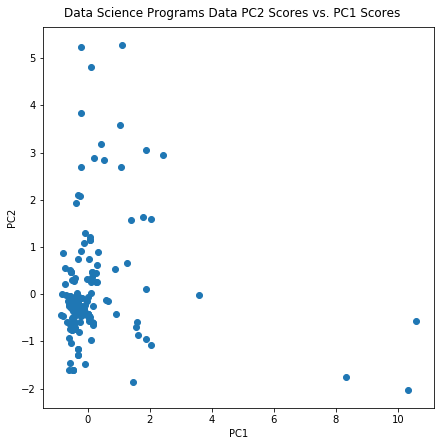

In [18]:
# Your code here
X = np.array(ds_features_df_2b.select('scores').rdd.map(lambda x: x['scores']).collect())
# now plot the data
fig, ax = plt.subplots();
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X[:,0], X[:,1])
fig.suptitle("Data Science Programs Data PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# for i, txt in enumerate(uni_names):
#     ax.annotate(txt, (X[i,0], X[i,1]))
plt.show();

idf => norm_idf => centered_idf => pca scores

In [19]:
# # Your code here
# X = np.array(ds_features_df.select('scores').rdd.map(lambda x: x['scores']).collect())
# # now plot the data
# fig, ax = plt.subplots();
# fig.set_figheight(7)
# fig.set_figwidth(7)
# ax.scatter(X[:,0], X[:,1])
# fig.suptitle("Data Science Programs Data PC2 Scores vs. PC1 Scores", y=.92)
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")

# # for i, txt in enumerate(uni_names):
# #     ax.annotate(txt, (X[i,0], X[i,1]))
# plt.show();

##### Grading Feedback Cell

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words and absolute loadings for the principal components 1 and 2, respetively.  Print both dataframes. Interpret the loadings.

In [20]:
# your code here (5 pts)

# loadings are in pipe_pca_fitted.stages[-1]
loadings = pipe_pca_fitted.stages[-1].pc.toArray()
pc1 = pipe_pca_fitted.stages[-1].pc.toArray()[:, 0].tolist() #loading vector
pc2 = pipe_pca_fitted.stages[-1].pc.toArray()[:, 1].tolist()

# word col is in thepipe_features_fitted.stages[2]
vocabulary=pipe_features_fitted.stages[2].vocabulary
# len(vocabulary) is 112

# create the Pandas dataframes of word and loadings
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})
# print(pc_loadings.shape) is (112,3)

In [21]:
pc1_pd =pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).rename(columns = {'load_pc1':'abs_loading'}).head(5)
print('the top 5 words and absolute loadings for the principal components 1')
pc1_pd

the top 5 words and absolute loadings for the principal components 1


,word,abs_loading
2,business,0.136173
5,mining,0.0738799
3,analytics,0.068668
8,intelligence,0.0608523
6,statistics,0.04373


In [22]:
pc2_pd=pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).rename(columns = {'load_pc2':'abs_loading'}).head(5)
print('the top 5 words and absolute loadings for the principal components 2')
pc2_pd

the top 5 words and absolute loadings for the principal components 2


,word,abs_loading
5,mining,0.168956
16,computational,0.168375
17,machine,0.164223
20,learning,0.164223
1,data,0.0826223


##### Grading Feedback Cell
-1: Need to sort the absolute values, not sort then take absolute value

Your interpretation here (5 pts): <br>
   Loadings describe how much each variable contributes to a particular principal component. Large loadings (positive or negative) indicate that a particular variable has a strong relationship to a particular principal component.<br>
As we can see, the variables that contribute most to principal component 1 are business, mining, analytics, intelligence, statistics.<br>
The variables that contribute most to principal component 2 are mining, computational, machine, learning and data.<br>
The variable "mining" contributes a lot to both principal components. The loading for "mining" on the first component is 0.07, and its loading on the second principal component is 0.17.<br>
My assumption is that the principal component 1 is more "business-related", while principal component 2 is more "technology-related". The principal component 1 likely reflects the broad application of data science in business world while principal component 2 may reflect the scientific researches aspect of data science programs. The word "mining" are important in both aspects in data science.

##### Grading Feedback Cell
Nice interpretation.  The loading vector coefficients represent covariance between the words and the loading vector if withStd=False in the standard scaler.  If withStd=True, the loading vector coefficients would represent correlation between the words and the loading vector.

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable named `explainedVariance` which represents the variance explained by components of the model. Finally, assign to a variable named `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.  The value best_k should be be 0 based - in other words present best_k assuming that you started counting at 0.

In [23]:
# your code here
# Reset ds_features_df
# ds_features_df=pipe_features.fit(ds_programs_text_df).transform(ds_programs_text_df)
# define a PCA transformer    
pca2=feature.PCA(k=50, inputCol='centered_features', outputCol='scores')
# Create a new pipeline pipe_pca2
pipe_pca2=Pipeline(stages=[center, pca2]).fit(ds_features_df)
# pipe_pca2=Pipeline(stages=[norm, center, pca2]).fit(ds_features_df)

In [24]:
# assign to 'explainedVariance' which represents the variance explained by components of the model.
explainedVariance=pipe_pca2.stages[-1].explainedVariance
# len(explainedVariance) is 50
# explainedVariance[0] is 0.07127759759886564

In [25]:
# Method 1
for k in range(len(explainedVariance)-1): 
    best_k=k
    if (explainedVariance[k+1]<0.01):
        break
print("the best_k is:",best_k)

the best_k is: 30


In [26]:
# Method 2
# best_k=next(k for k in range(len(explainedVariance)-1) if explainedVariance[k+1]<0.01)
# best_k

##### Grading Feedback Cell

# Question 6: (10 pts)

Create a new pipeline for PCA called pipe_pca3 (similar to pipe_pca2 above) where you fit the maximum possible number of principal components for this dataset. Create a scree plot and a plot of cumulative variance explained.

In [27]:
# your code here
# Reset ds_features_df
# ds_features_df=pipe_features.fit(ds_programs_text_df).transform(ds_programs_text_df)
# define a PCA transformer    
pca3=feature.PCA(k=len(vocabulary), inputCol='centered_features', outputCol='scores')
# pca3.getK() is 112
pipe_pca3=Pipeline(stages=[center, pca3]).fit(ds_features_df)

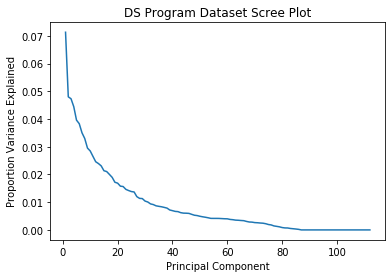

In [28]:
# Create a scree plot 
plt.figure()
explained_var = pipe_pca3.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("DS Program Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained");

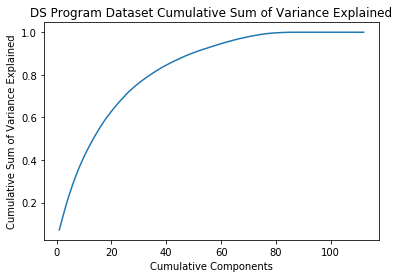

In [29]:
# a plot of cumulative variance explained.
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("DS Program Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained");

In [30]:
## check the k that can explain 80% of the original data
# for k in range(len(cum_sum)-1): 
#     best_k=k
#     if (cum_sum[k+1]>0.8):
#         break
# print(best_k) gives us 33.

# cum_sum[40] gives us 0.852108403998239
# cum_sum[50] gives us 0.9087077288810588
# cum_sum[10] 0.4413387368510648

##### Grading Feedback Cell

# Question 7: (10 pts)
Create a pipeline named pipe_pca4 (similar to pipe_pca3 above) that computes the first 2 principal components.  Add a kmeans objects to the end of pipe_pca4 and compute kmeans with k = 5.  Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment.  Include a plot legend.

In [31]:
# your code here
# Reset ds_features_df
# ds_features_df=pipe_features.fit(ds_programs_text_df).transform(ds_programs_text_df)   
# define a Normalizer transformer which will normalize vectors to unit length.
norm = feature.Normalizer(inputCol="centered_features", outputCol="norm_features", p=2.0)
# the PCA transformer is defined above
# define a KMeans clustering object
kmeans = clustering.KMeans(k=5, featuresCol='norm_features', predictionCol='kmeans_feat')
# Create a pipeline named pipe_pca4
pipe_pca4=Pipeline(stages=[center, norm, pca, kmeans]).fit(ds_features_df)

In [32]:
ds_pca4_df=pipe_pca4.transform(ds_features_df)
# ds_pca4_df.groupBy('kmeans_feat').count().show()

In [33]:
# PCA socres
X = np.array(ds_pca4_df.select('scores').rdd.map(lambda x: x['scores']).collect())
# Kmeans_feat
clusters = np.array(ds_pca4_df.select("kmeans_feat").rdd.map(lambda x: x['kmeans_feat']).collect())
# clusters = ds_pca4_df.select("kmeans_feat").rdd.map(lambda x: x['kmeans_feat']).collect()
# np.unique(clusters) gives us array([0, 1, 2, 3, 4])

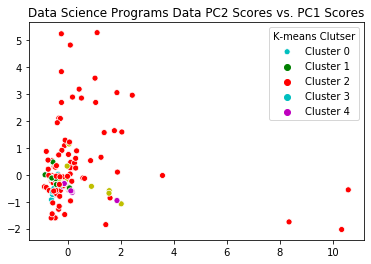

In [34]:
# Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment. 
# Include a plot legend.
legend = []
for i in np.unique(clusters):
    legend.append('Cluster {0}'.format(i))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusters,palette=['g','r','c','m','y'],legend='full') #"
plt.title('Data Science Programs Data PC2 Scores vs. PC1 Scores')
plt.legend(legend,title='K-means Clutser')
plt.show();

##### Grading Feedback Cell
-1 The title is explicit but I do prefer to have axis labels

# Question 8: (10 pts)
Starting with pipe_pca2, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  Extract the output from the standard scaler column from the first row of pca_fun and store in a variable called `z`. Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors. Save the 10 projected pca scores in a varialbe called `projection`.  Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named `model_scores`.  Print `projection` and `model_scores`.  Compare `projection` to `model_scores` and explain why they are the same or different. 

In [35]:
# your code here (5 pts)
# Reset ds_features_df
# ds_features_df=pipe_features.fit(ds_programs_text_df).transform(ds_programs_text_df)
# ds_features_df.count() gives us 222
# transform the pipe_pca2 and save the resulting as pca_fun
pca_fun=pipe_pca2.transform(ds_features_df)
# pca_fun.toPandas().head()

In [36]:
# Extract the output from the standard scaler column from the first row of pca_fun 
# and store in a variable called z.
z=pca_fun.select('centered_features', 'scores').first()['centered_features']
# len(z) gives us 112

In [48]:
# Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors.
loadings = pipe_pca2.stages[-1].pc.toArray()
# loadings.shape is (112, 50)
projection = z.dot(loadings[:,:10])

(112, 50)


In [38]:
# Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named model_scores
model_scores=pca_fun.select('centered_features', 'scores').first()['scores'][:10]

In [39]:
# Print projection and model_scores. 
print('projection: ',projection)
print('model_scores: ',model_scores)

projection:  [-0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739 -0.78124129
 -1.46182952 -0.38379532  0.01341778 -0.24463091]
model_scores:  [-0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739 -0.78124129
 -1.46182952 -0.38379532  0.01341778 -0.24463091]


In [40]:
# Compare projection to model_scores and explain why they are the same or different.
diffs = model_scores-projection
diffs

array([-1.11022302e-16, -1.11022302e-16,  2.22044605e-16,  1.11022302e-16,
        5.55111512e-17, -7.77156117e-16,  8.88178420e-16,  5.55111512e-17,
        7.45931095e-17,  1.94289029e-16])

##### Grading Feedback Cell

Your explanation here (5 pts): <br>
As we can we, the projection and model_scores are different from each other. However, the difference is so small that it can be ignored.<br>


The reason why they are almost the same is that we fit pipe_pca2 with 50 principal components. 
As we can see from the plot of cumulative variance explained in question 6, 50 principal components explain about 90% of variance of the original data set. 50 is big enough to make the lost infomration sifficiently small. Though we cannot restore the exact original data set from the 50 principal components, we are able to capture about 90% of the original variance, which is really close to the original data set.



##### Grading Feedback Cell
-5: I think you are confusing the forward transform and inverse transorm.  In this question you are manually computing the scores.  The fact that the manually computed scores match the scores in the scores column indicate you did the projection correct.  Using more or less than 10 loading vectors to compute the scores will only affect how many scores are calculated, not how accurate the scores are.  A more appropriate answer is that the manual projection is shown to be correct because it matches the projection made by the PCA object to a small rounding error.

# Question 9: (10 pts)
Using PCA loading vectors, perform an inverse transform on the `projection` variable and store the result in a variable named inverse.  Print `inverse` and the original `z` data.  Explain why the inverse data is the same as `z` (or really close to `z`), or why it is different than `z`.  

In [41]:
# your code here (5 pts)
# Using PCA loading vectors perform an inverse transform on the projection variable and store the result in a variable named inverse.
inverse=loadings[:,:10].dot(projection[:10])
# or inverse=projection.dot(loadings[:,:10].T)
# len(inverse) is 112
# loadings[:,:10].shape is (112, 10)
# projection[:10].shape is (10,)

In [42]:
# Print inverse and the original z data.
print("inverse: ",inverse)
print("original z: ",z)

inverse:  [-3.98181012e-02  2.43205863e-01 -6.31585720e-01 -2.69959353e-01
  3.39563694e-01  1.21250081e-01  2.06481351e+00 -2.51147047e-01
 -3.90968288e-01  7.39924107e-03  6.38829687e-02  2.89489245e-01
 -1.12177016e-01  1.90822768e-01 -1.07907430e-01  1.00266093e-01
 -1.26910287e-01 -1.42628181e-01 -3.52566821e-01  3.04623232e-01
 -1.42628181e-01 -3.62013312e-01 -2.75872731e-01 -2.98456354e-01
 -2.46281587e-01 -2.45085926e-01 -1.10652164e-01  2.57462252e-01
  3.40325429e-02  8.61291153e-01 -9.60684737e-03  5.19727913e-01
 -3.16747128e-02  6.26197071e-02 -3.28031053e-02 -1.08211389e-01
 -1.59284445e-01 -1.08211389e-01 -1.29053476e-02  8.86374457e-03
 -7.29644989e-02 -3.45722474e-02 -5.95006813e-02 -3.99589979e-02
  8.33838510e-03 -3.24773205e-02 -3.21988135e-02  2.53951184e-01
 -6.21821418e-02 -4.86672631e-02 -8.90724282e-02 -1.16611637e-01
 -4.86672631e-02 -7.92319432e-02 -5.01017567e-03  4.68632526e-02
 -1.92067776e-02 -1.28394580e-02  1.07116525e-02 -5.48752959e-02
 -1.14649098e-0

In [43]:
# Compare the inverse data with z
diff=z-inverse
diff

DenseVector([0.097, 0.0621, 0.1361, -0.093, 0.5246, -0.3622, 0.1539, 0.0122, 0.1719, -0.2138, -0.2726, -0.4892, -0.0849, -0.361, -0.0713, -0.2624, -0.0321, 0.0071, 0.217, -0.4492, 0.0071, 0.2265, 0.136, 0.1935, 0.1414, 0.1402, 0.0057, -0.351, -0.1317, -0.9427, -0.0718, 3.0143, -0.0368, -0.131, -0.0356, 0.0539, 0.1049, 0.0539, -0.0414, -0.0477, 0.0341, -0.0042, 0.0207, 0.0011, -0.0472, -0.0063, -0.0066, -0.2928, 0.0234, 0.0099, 0.0466, 0.0778, 0.0099, 0.0404, -0.0338, -0.0857, -0.002, -0.0084, -0.0319, 0.0336, 0.0934, -0.0193, -0.0275, -0.0084, 0.0336, -0.0033, -0.0345, 0.0155, -0.0286, 0.0934, -0.0558, -0.0558, 0.0103, 0.0934, 0.0427, -0.0096, 0.0233, 0.0029, 0.0853, -0.0096, 0.0132, -0.0009, 0.0853, 0.0025, 0.0015, -0.0245, 0.0082, 0.0103, 0.0934, -0.0084, 0.0123, 0.0328, 0.0024, -0.0246, 0.0328, -0.0345, 0.0934, -0.263, 0.015, -0.0202, 0.0082, -0.002, -0.0084, -0.0202, 0.0129, -0.0246, -0.0252, 0.0647, -0.0362, -0.009, -0.0127, -0.005])

##### Grading Feedback Cell

Your explanation here (5 pts):<br>
The inverse data is different than z.<br>

The more loadings we use for the inverse transform, the closer the approximation to the original observation row. In this case, we only use 10 principal components to restore the original dataset. 112x10 loadings and 10x1 projection only capture about 45% of the variance of the original dataset. So the inverse data is different than z.

##### Grading Feedbck Cell

# Question 10: (10 pts)

Think about the cumulative variance and the scree plot from the question above.  If you were building a machine learning model, how many principal components would you pick for your model.  Explain why.  

Your Answer Here:<br>

I would pick 35 to 40 principal components to build a machine learning model.

To find the proper number of principal components, we should check a marked drop in the percentage of explained variation in the scree plot and ignore those principal components that explain relatively little variation. Here, first 35 to 40 principal components are able to explain more than 0.01 variance, and subsequent principal components explain much less.


The Cumulative variance plot gives us the percentage of variance accounted for by the first n components. The acceptable level of variance depends on our application. For descriptive purposes, I would like 80% of the variance explained. However, if I will perform other analyses on the data, I may need at least 90% of the variance explained by the principal components.

##### Grading Feedback Cell